In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

Using TensorFlow backend.


# Load in Xome and Genome data

In [2]:
 xome_data = pd.read_csv('xome-tools-all-ryantest.csv',sep = '\t')

In [5]:
genome_data = pd.read_csv('genome-tools-all-ryantest.csv',sep='\t')

In [6]:
xome_types = xome_data.instance.unique()
xome_tools = xome_data.tool.unique()
xome_tags = xome_data.tag.unique()

In [8]:
genome_types = genome_data.instance.unique()
genome_tools = genome_data.tool.unique()
genome_tags = genome_data.tag.unique()

# for each tool and each instance type, look for outliers


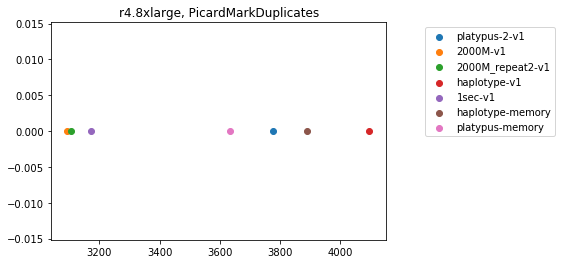

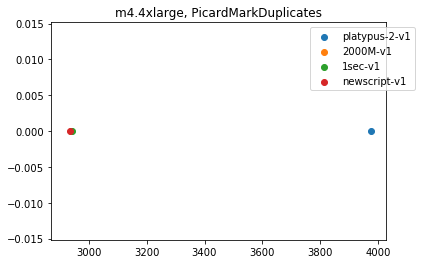

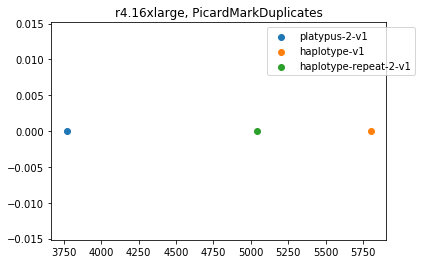

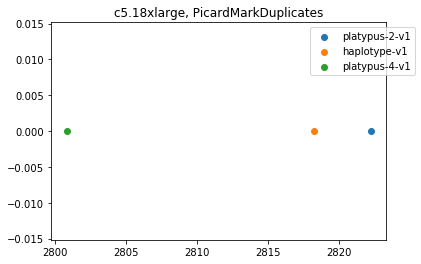

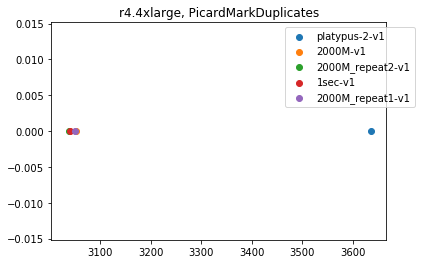

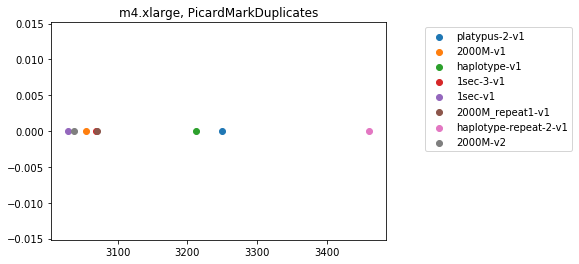

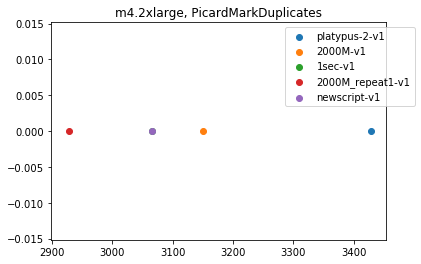

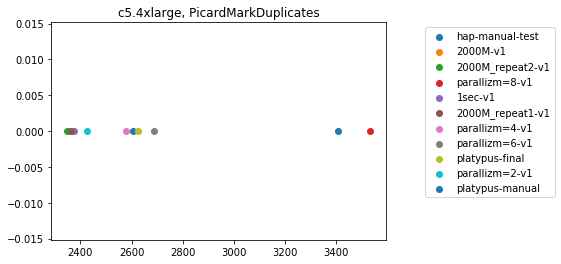

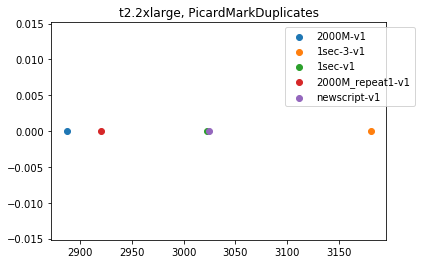

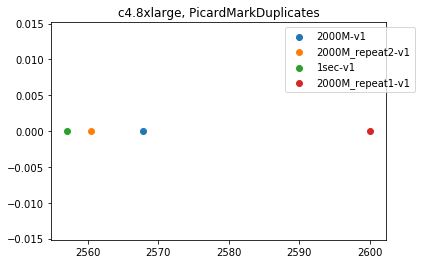

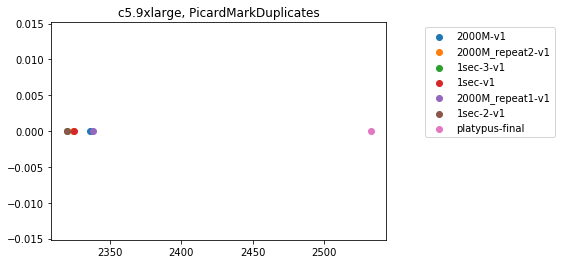

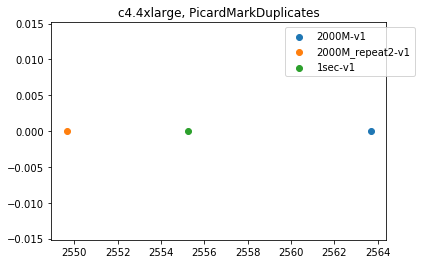

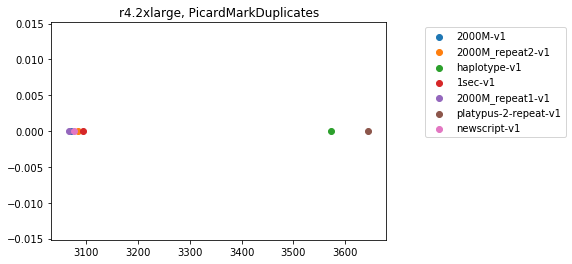

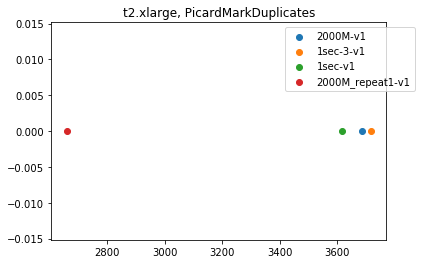

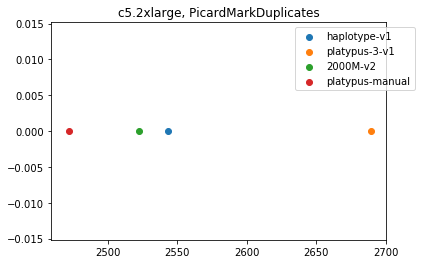

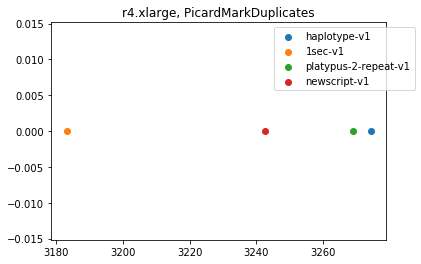

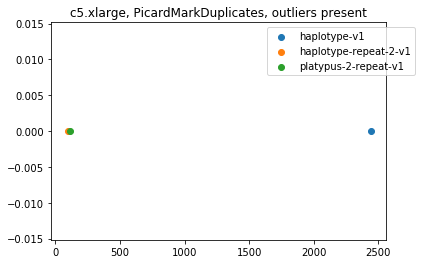

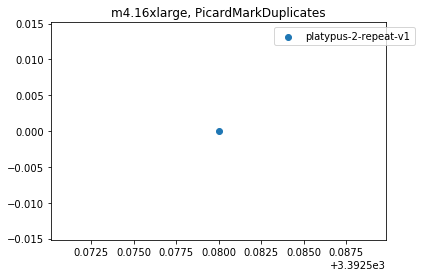

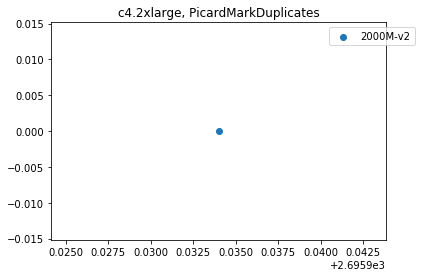

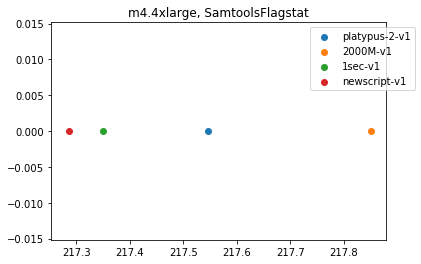

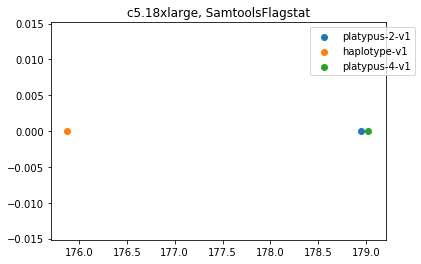

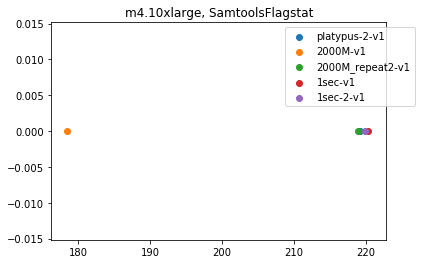

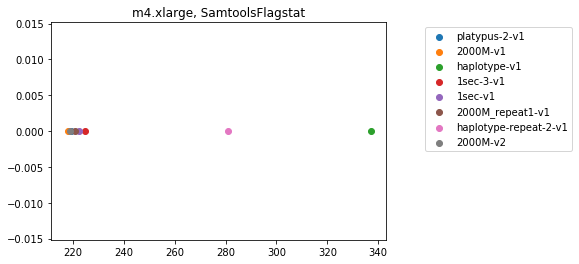

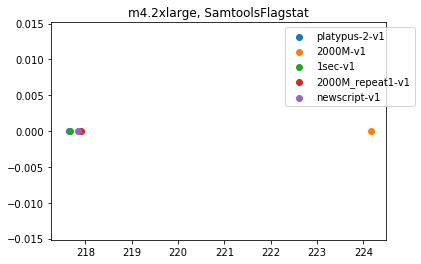

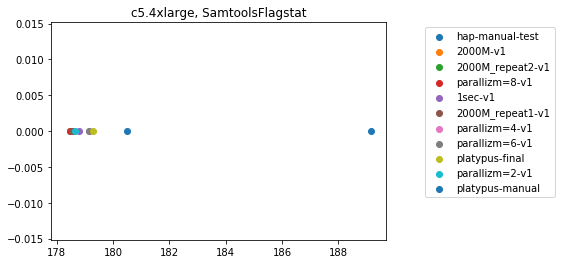

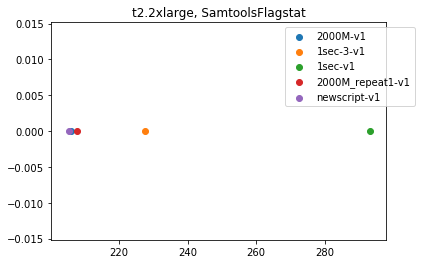

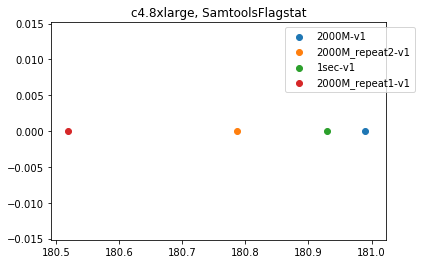

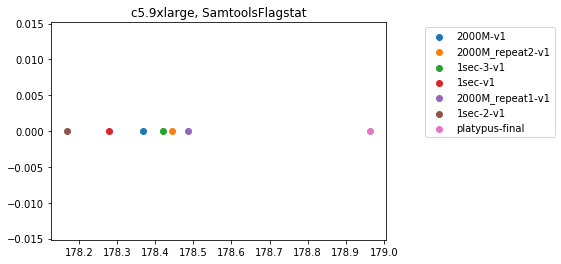

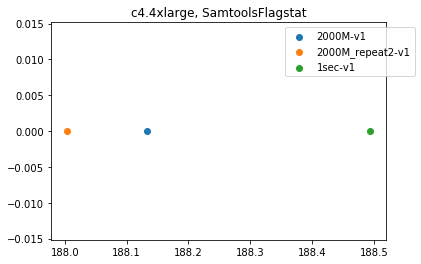

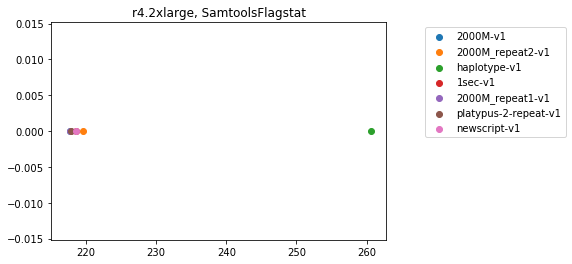

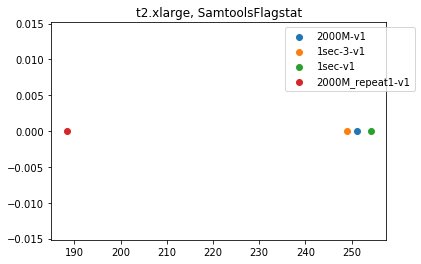

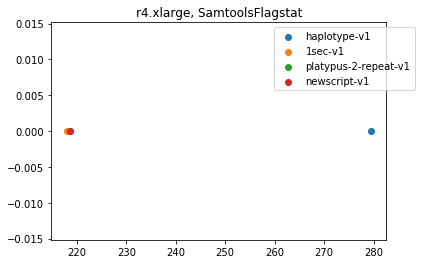

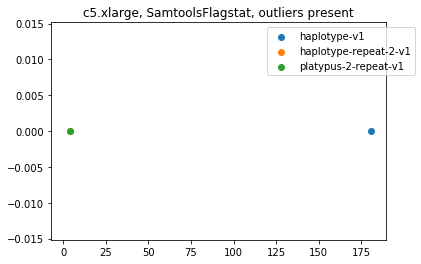

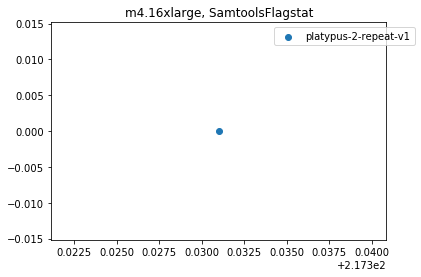

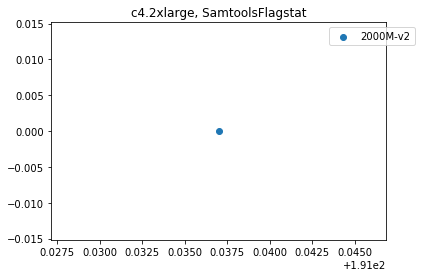

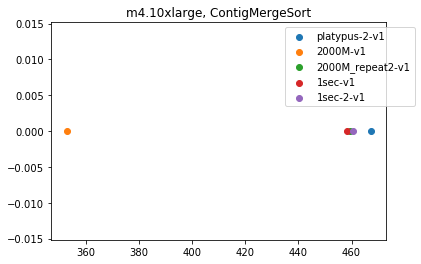

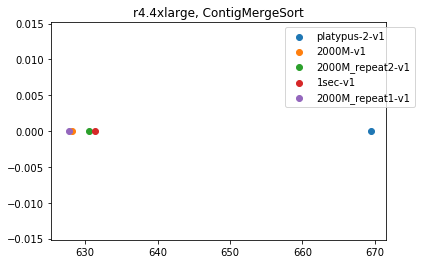

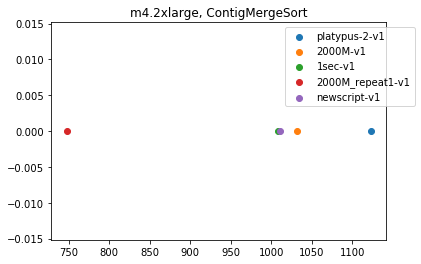

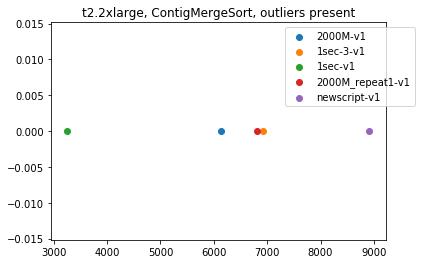

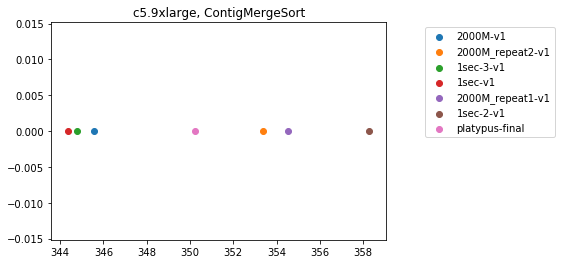

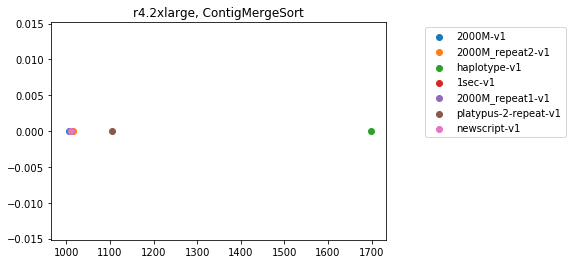

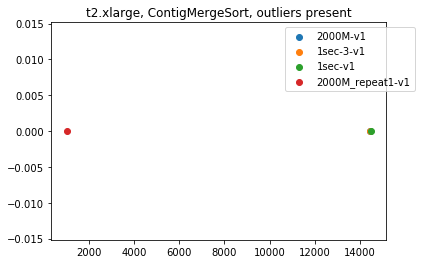

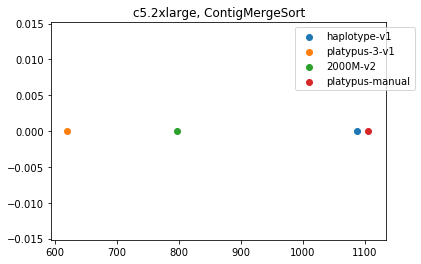

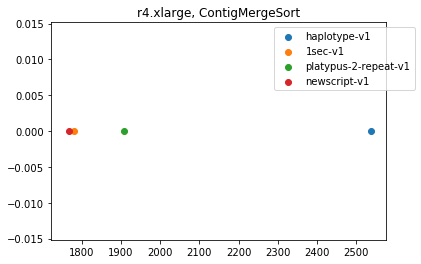

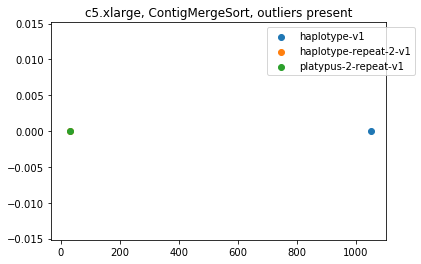

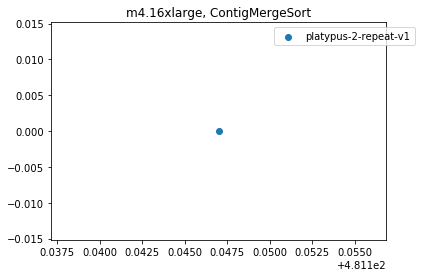

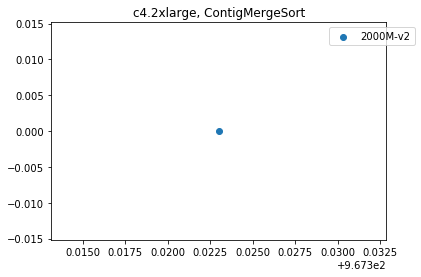

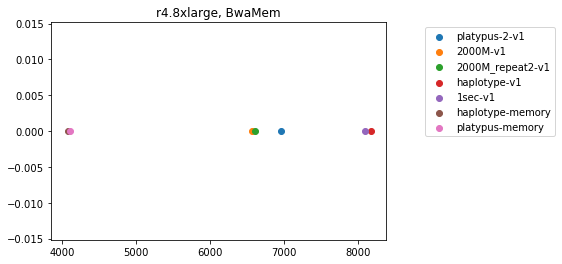

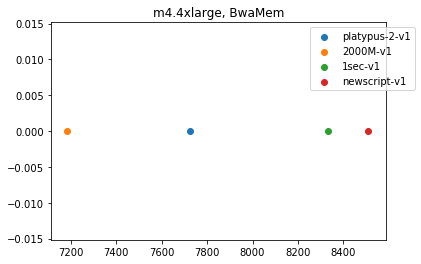

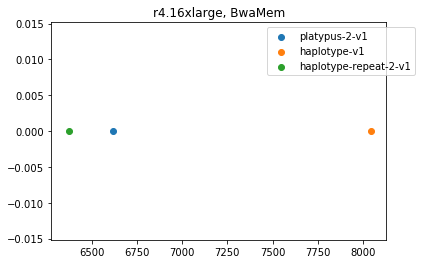

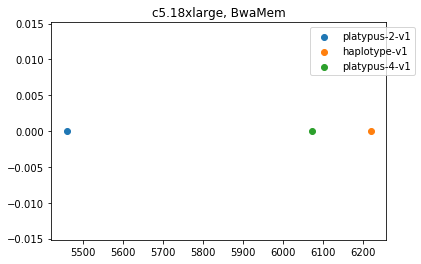

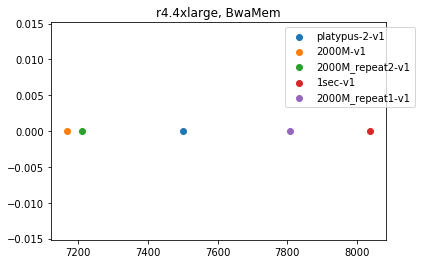

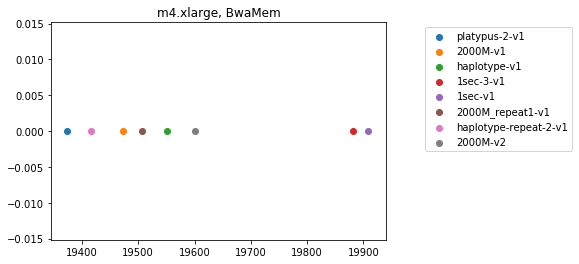

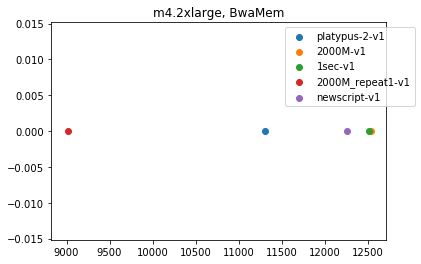

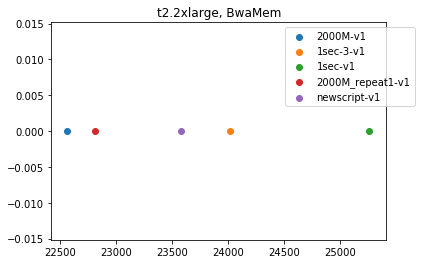

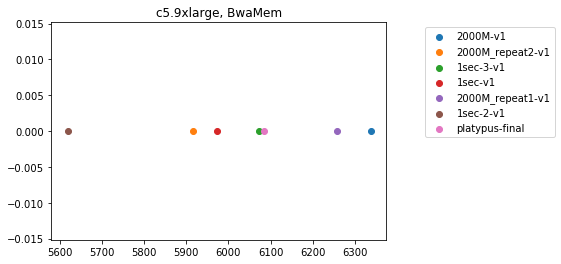

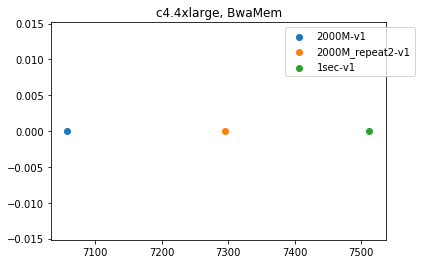

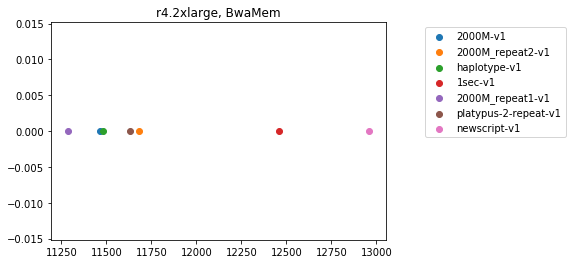

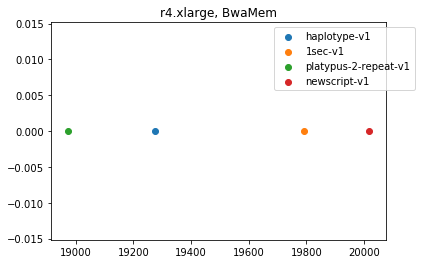

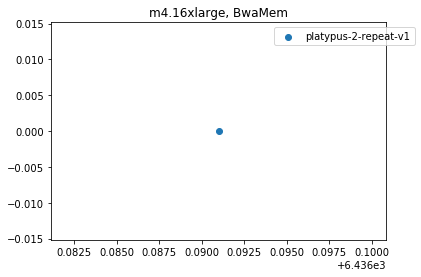

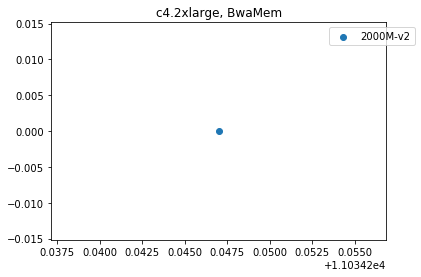

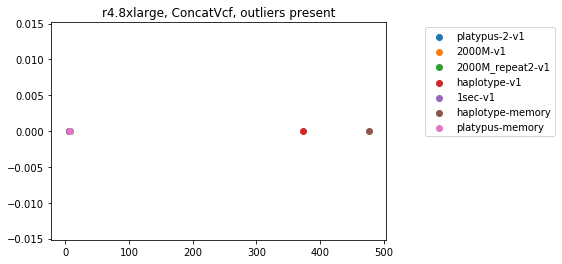

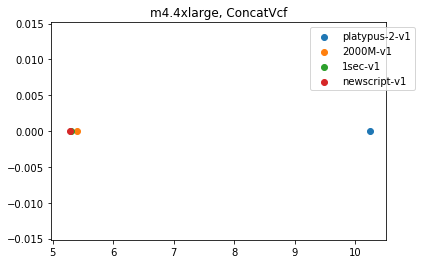

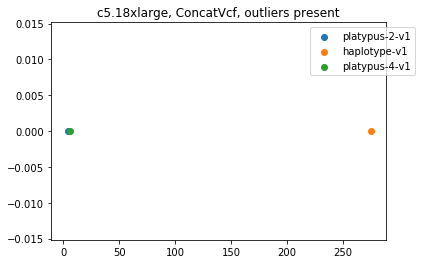

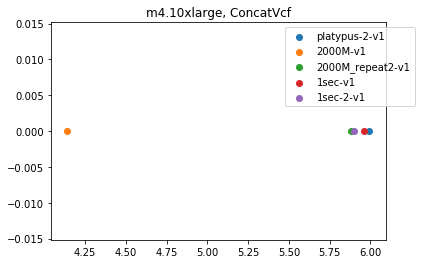

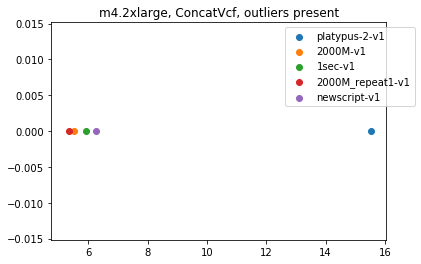

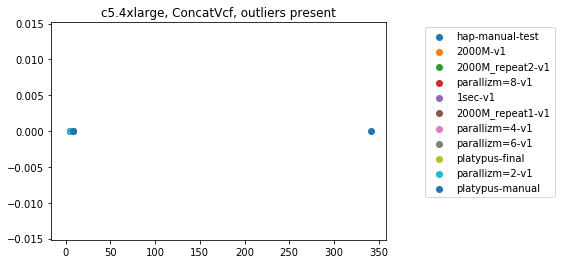

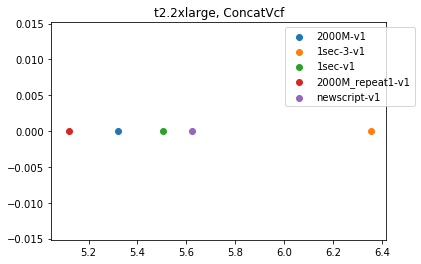

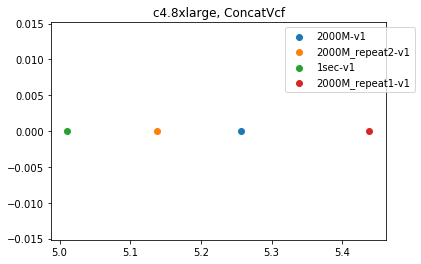

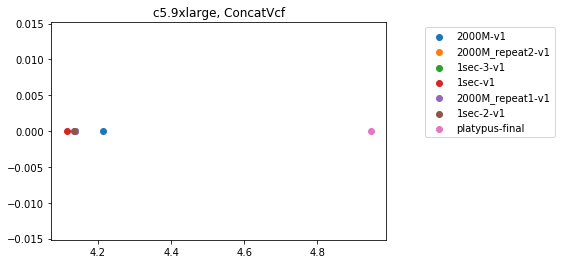

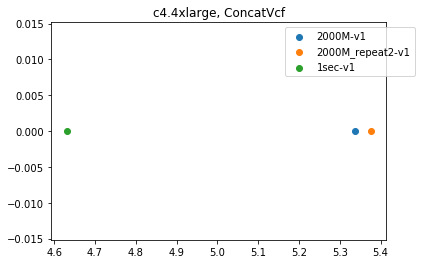

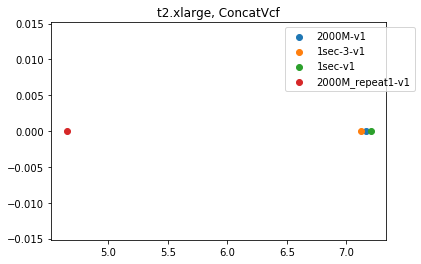

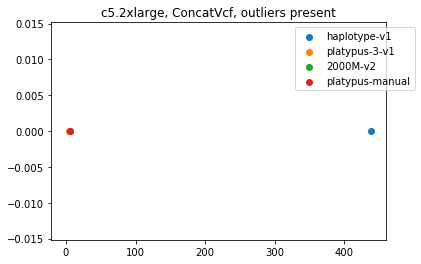

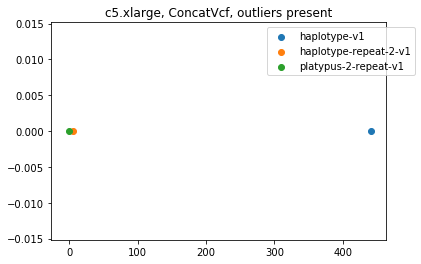

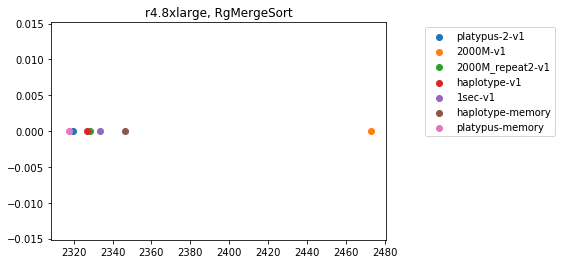

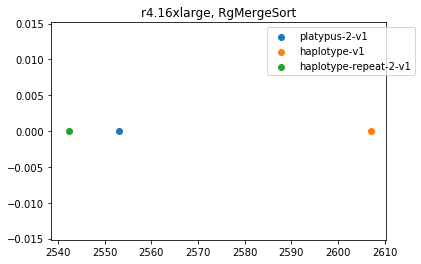

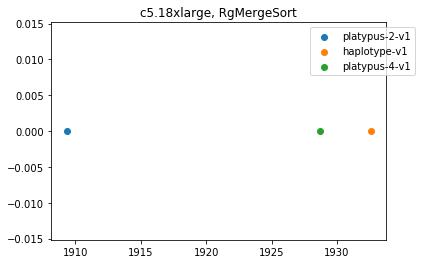

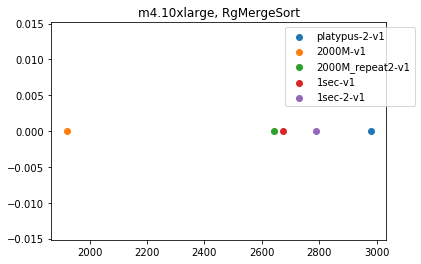

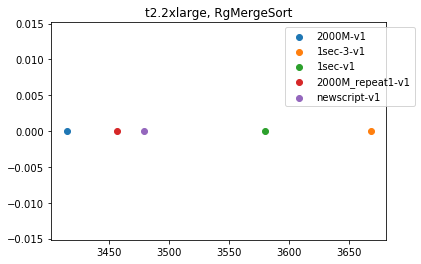

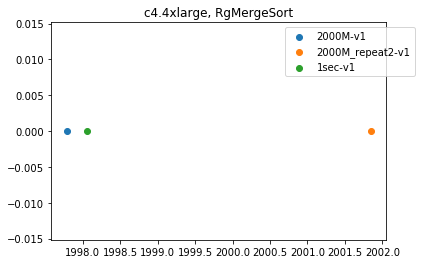

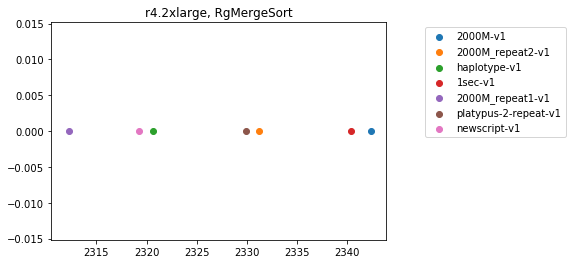

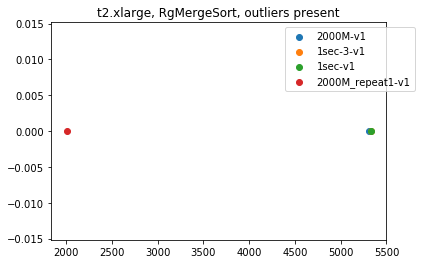

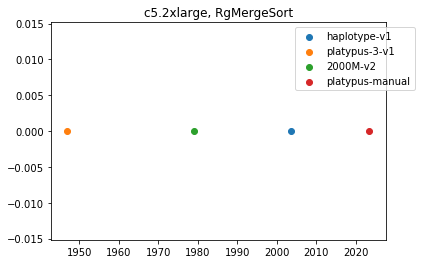

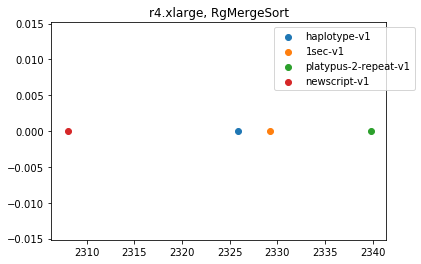

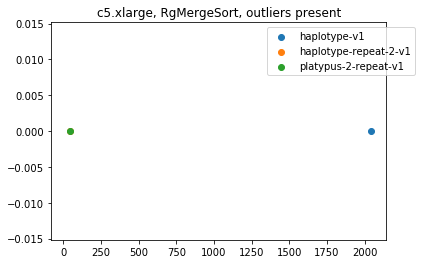

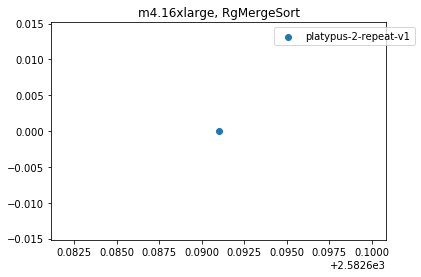

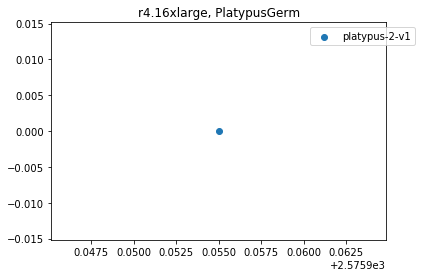

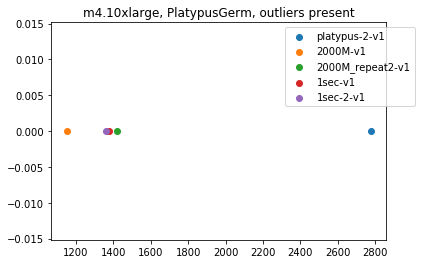

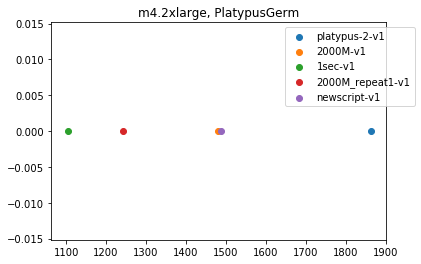

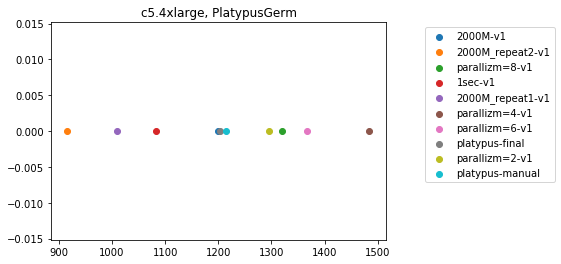

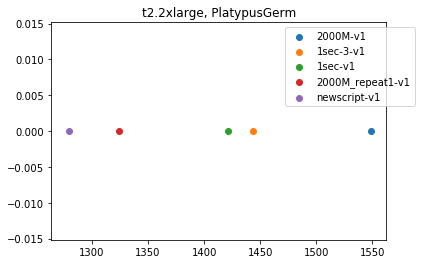

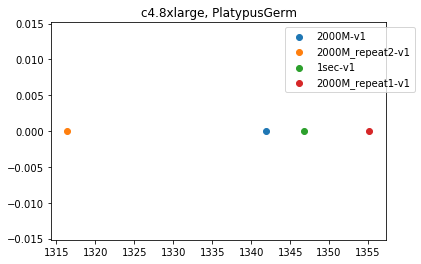

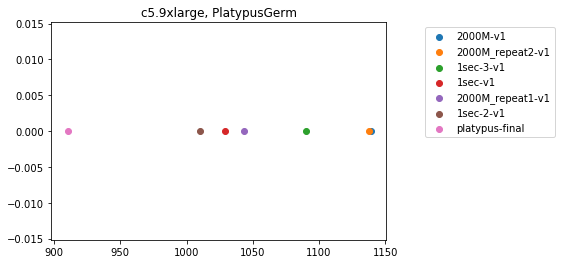

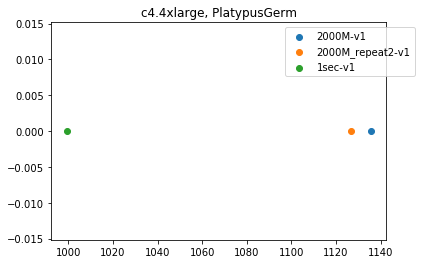

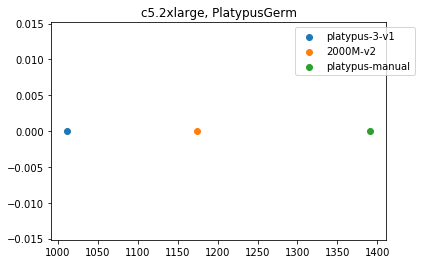

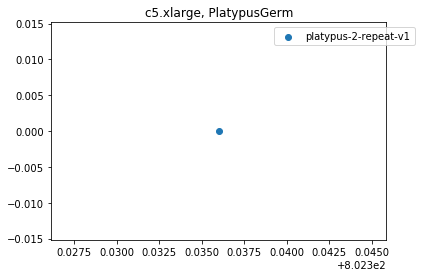

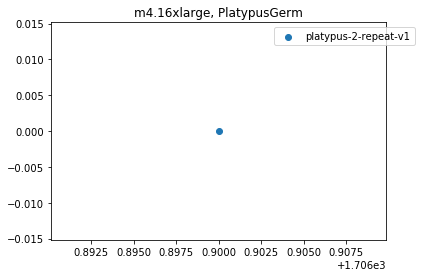

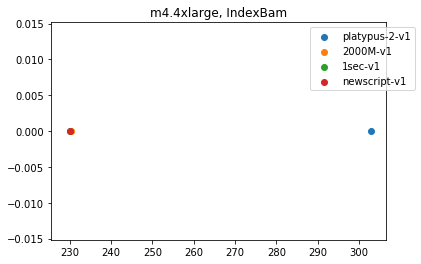

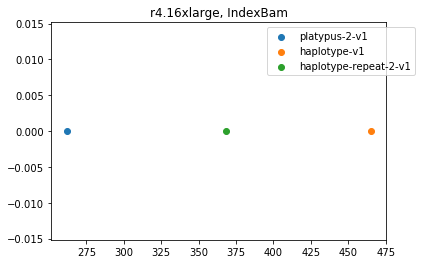

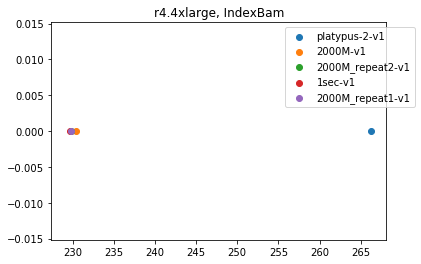

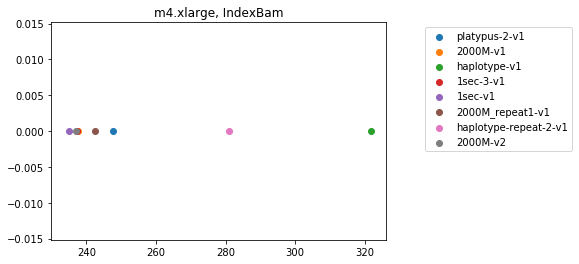

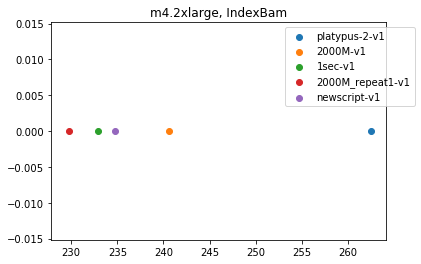

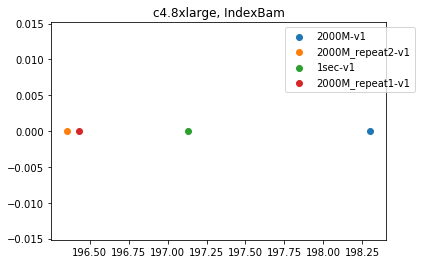

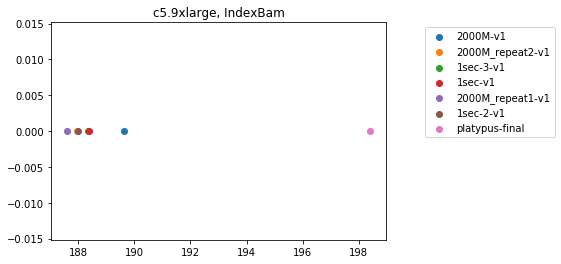

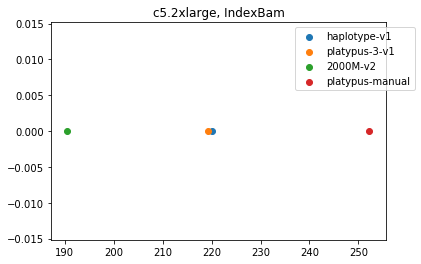

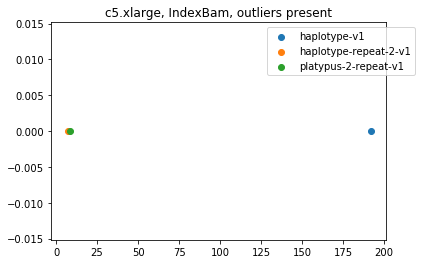

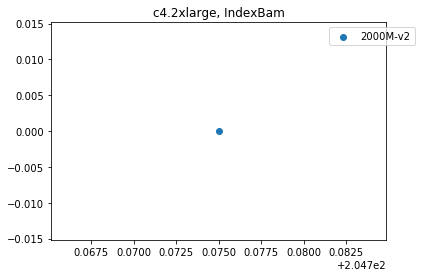

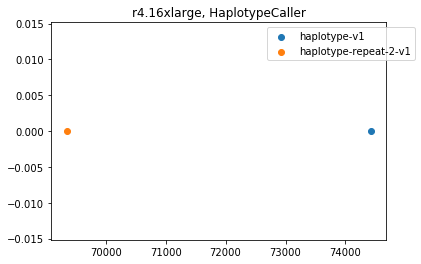

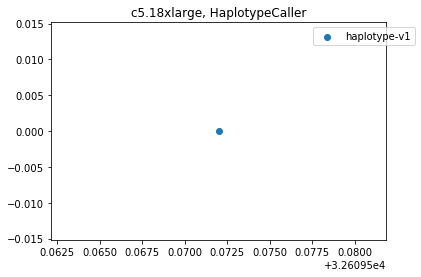

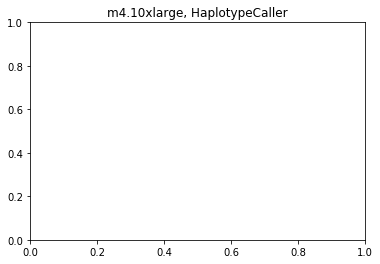

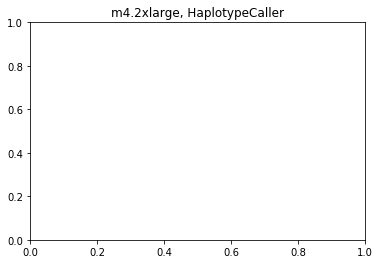

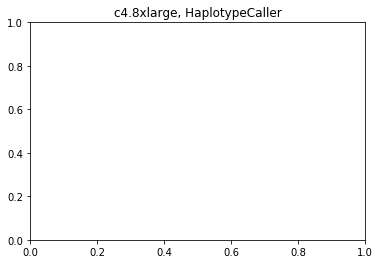

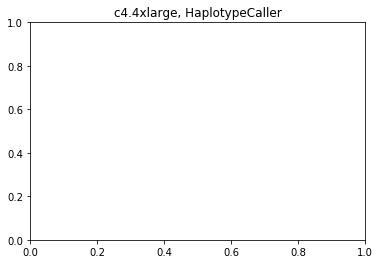

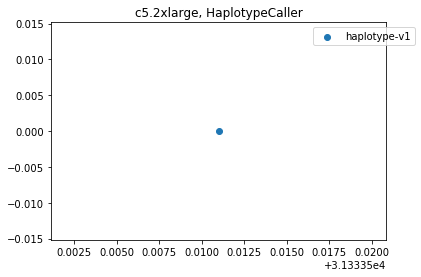

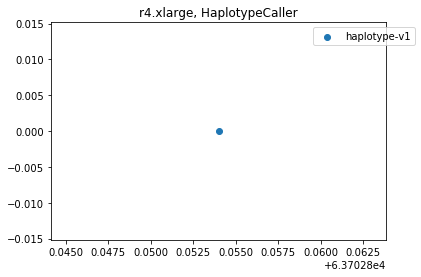

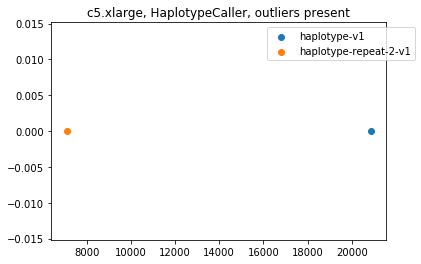

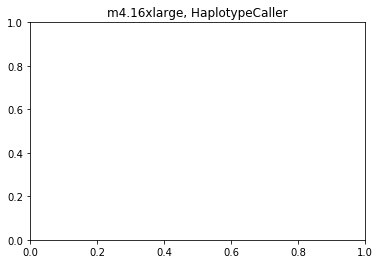

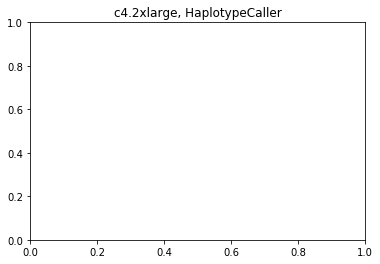

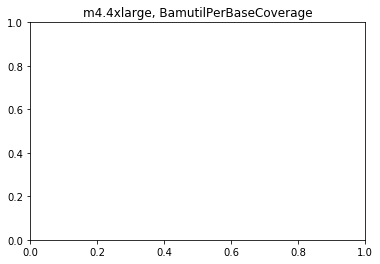

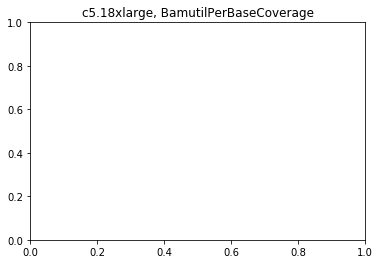

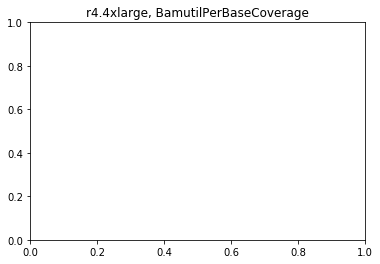

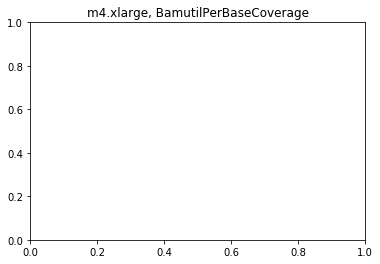

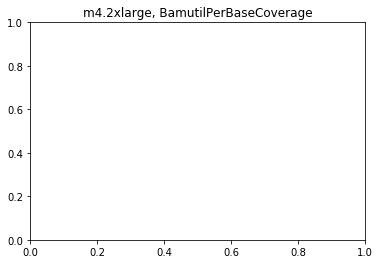

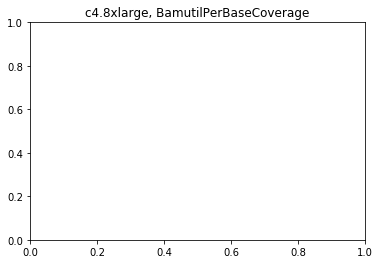

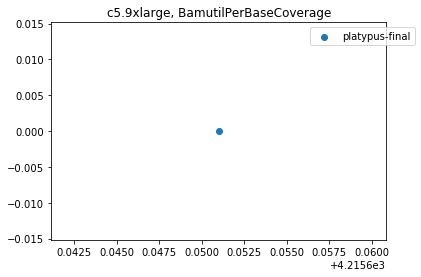

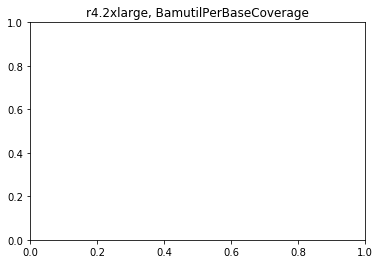

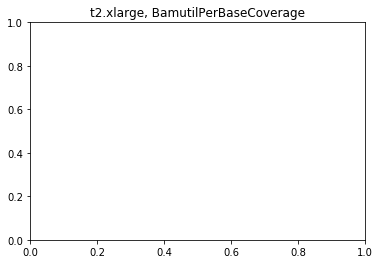

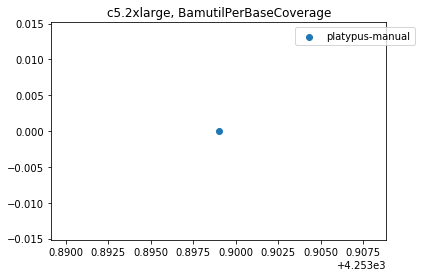

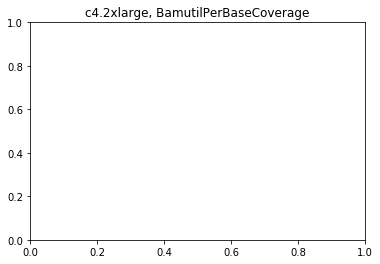

In [41]:
for k in xome_tools:
    for p in xome_types:
        l = ''
        ser_max = 0
        ser_min = 100000
        temp = xome_data[(xome_data.tool==k) & (xome_data.instance==p)]
        fig, ax = plt.subplots()
        for t in xome_tags:
            ser = temp[temp.tag==t].duration
            if len(ser)>0:
                zeroes = len(ser)*[0]
                ax.scatter(ser,zeroes,label=t)
                if ser.max()>ser_max:
                    ser_max = ser.max()
                if ser.min()<ser_min:
                    ser_min = ser.min()
                
        if ser_max > 2*ser_min:
            l=', outliers present'
        legend = ax.legend(bbox_to_anchor=(1.1, 1))
        plt.title(str(p)+', '+ str(k) + str(l))
        plt.show()

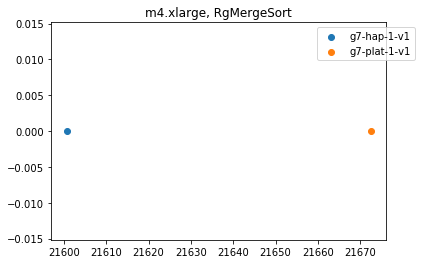

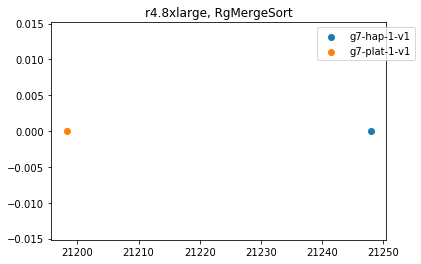

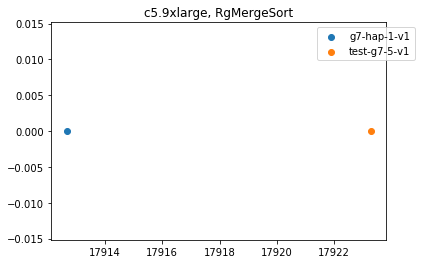

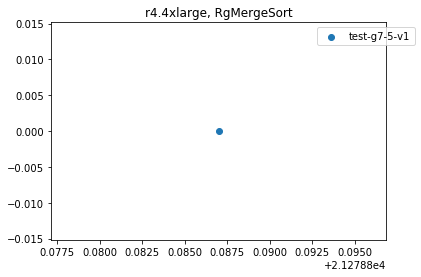

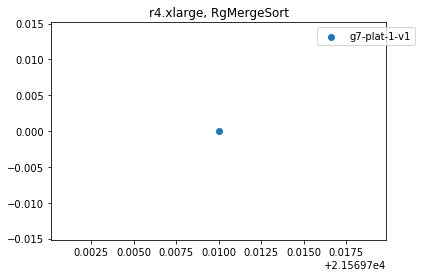

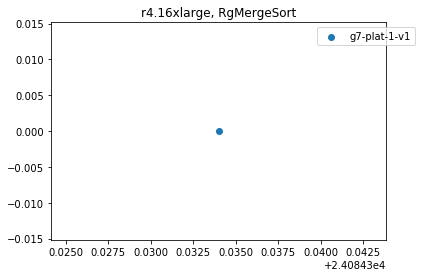

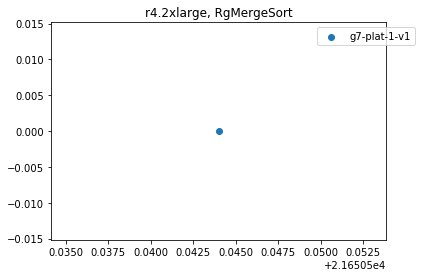

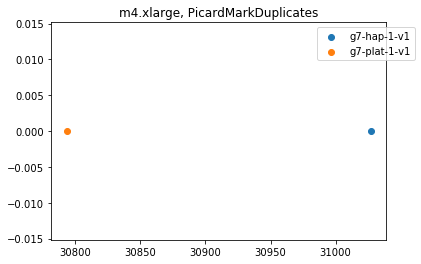

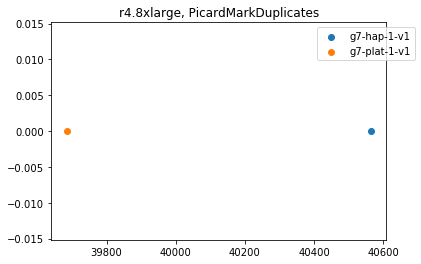

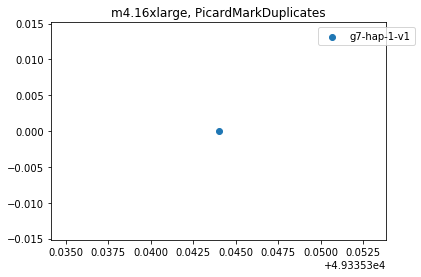

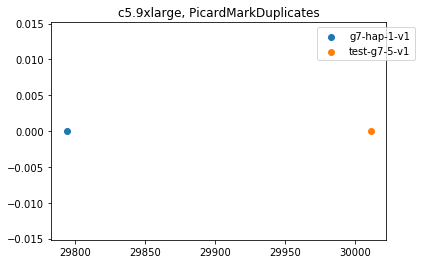

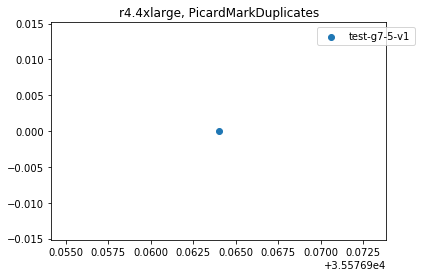

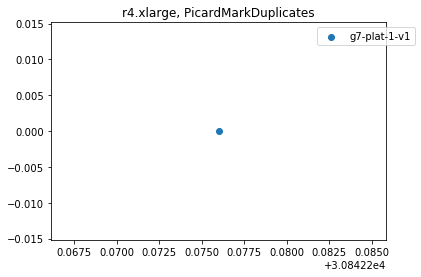

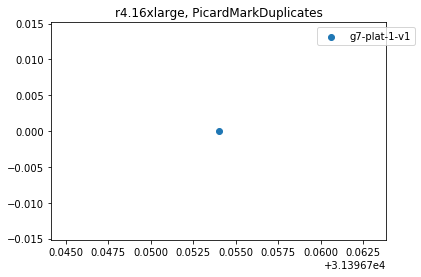

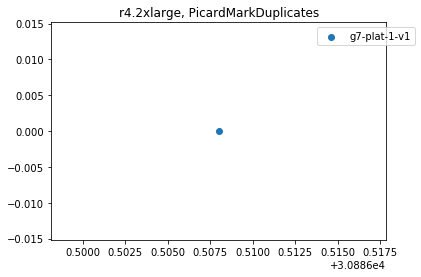

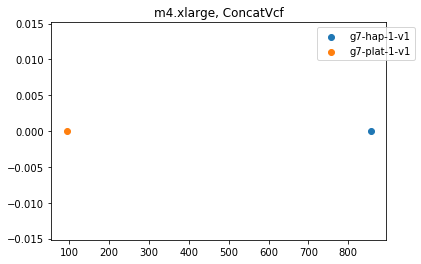

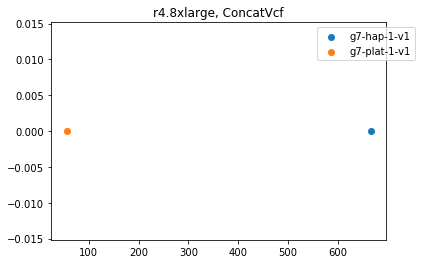

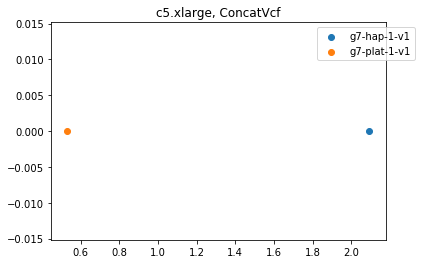

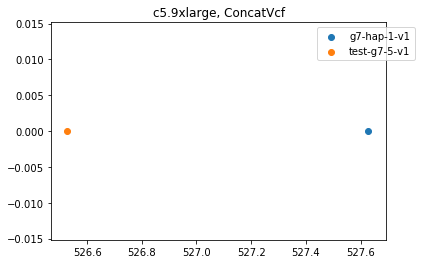

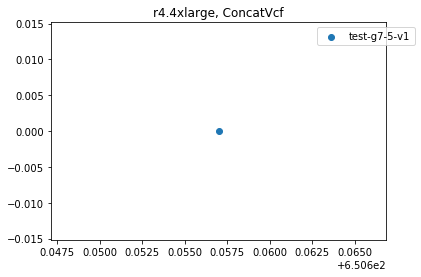

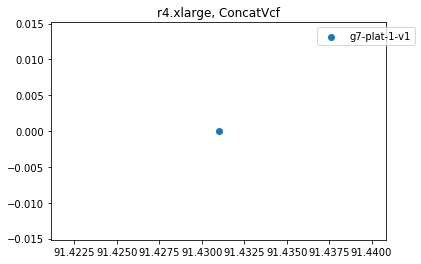

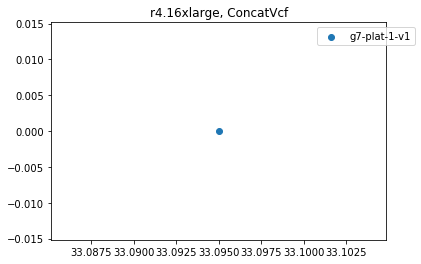

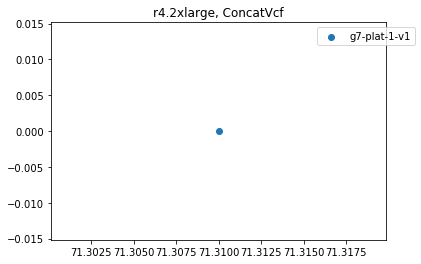

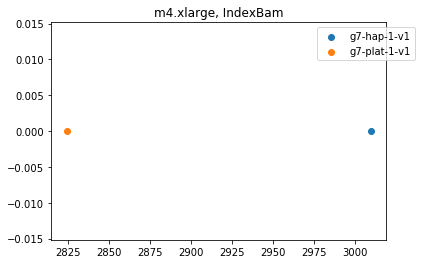

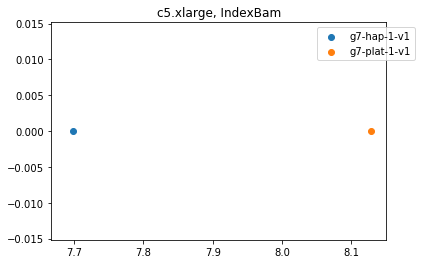

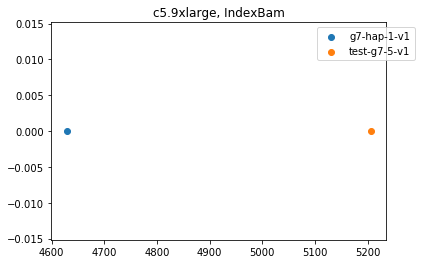

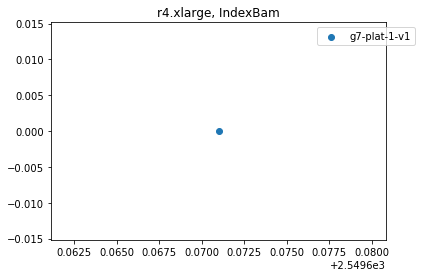

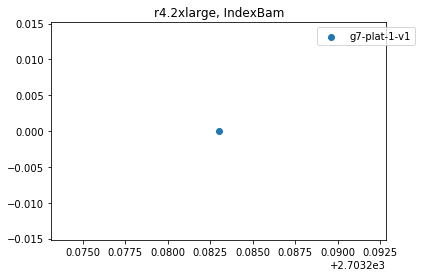

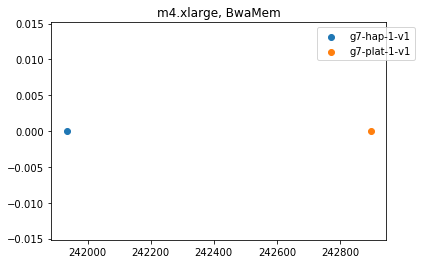

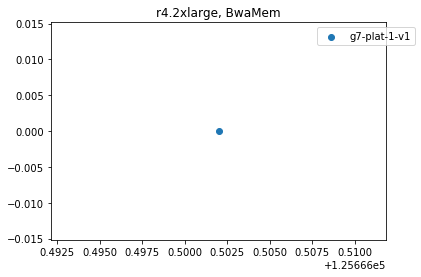

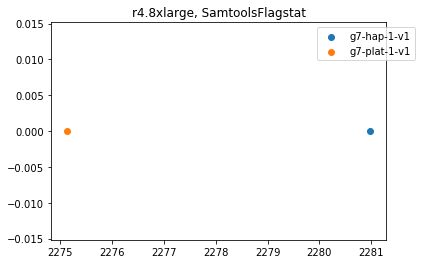

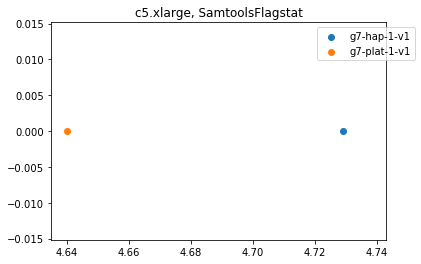

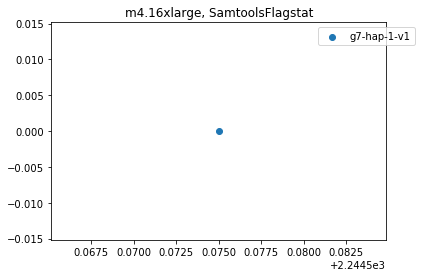

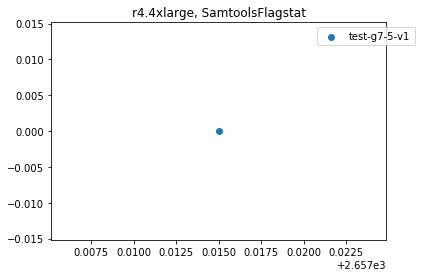

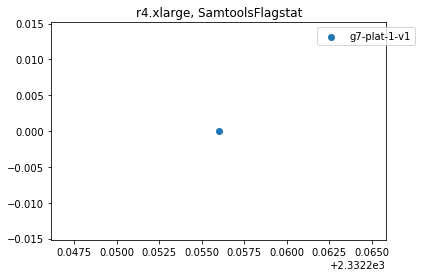

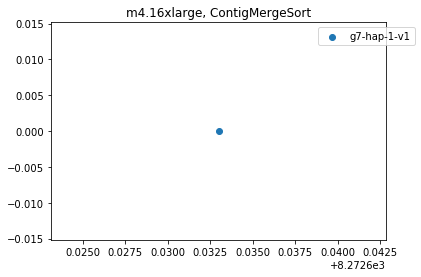

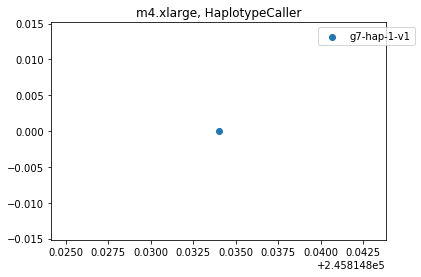

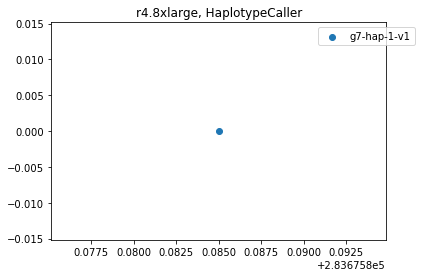

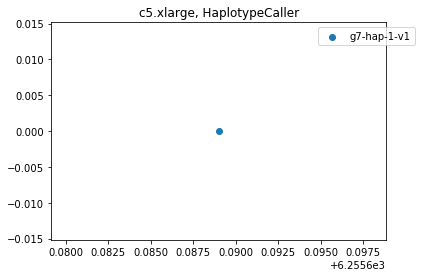

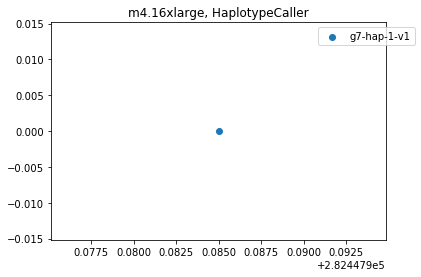

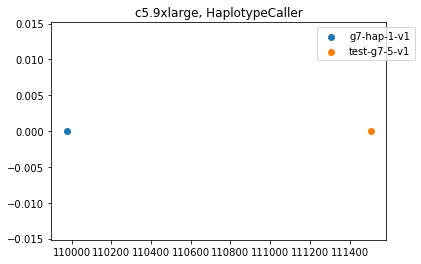

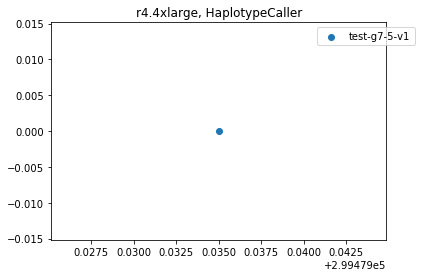

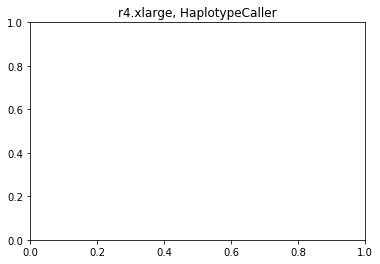

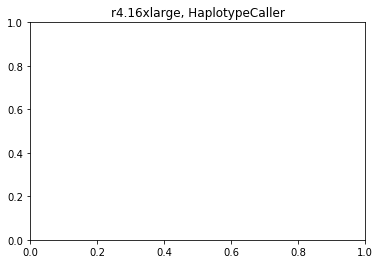

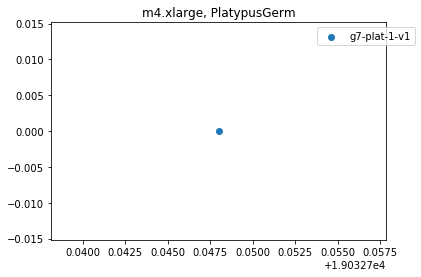

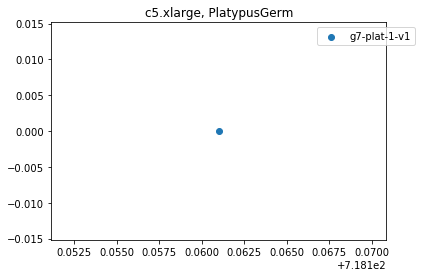

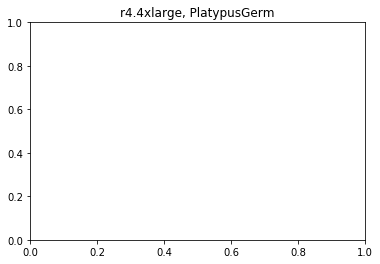

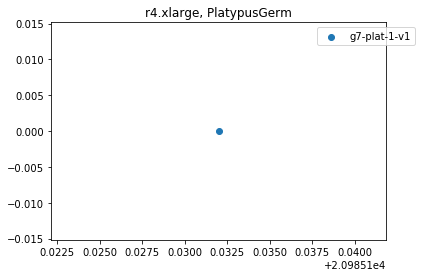

In [42]:
for k in genome_tools:
    for p in genome_types:
    
        temp = genome_data[(genome_data.tool==k) & (genome_data.instance==p)]
        fig, ax = plt.subplots()
        for t in genome_tags:
            ser = temp[temp.tag==t].duration
            if len(ser)>0:
                zeroes = len(ser)*[0]
                ax.scatter(ser,zeroes,label=t)
                if ser.max()>ser_max:
                    ser_max = ser.max()
                if ser.min()<ser_min:
                    ser_min = ser.min()
                
        if ser_max > 2*ser_min:
            l=', outliers present'
        
        legend = ax.legend(bbox_to_anchor=(1.1, 1))
        plt.title(str(p)+', '+str(k))
        plt.show()

# add resource information to primary dataframes

In [12]:
xome_info = pd.DataFrame(columns = ['cpus','mem'])

In [13]:
genome_info = pd.DataFrame(columns = ['cpus','mem'])

In [14]:
xome_data = xome_data.join(xome_info)

In [15]:
genome_data = genome_data.join(genome_info)

In [17]:
instances = pd.read_csv('instances.csv')[['instance','cores','mem']]

In [19]:
for k in range(xome_data.instance.size):
    temp = instances[instances.instance==(xome_data.iloc[k].instance)]
    xome_data.loc[k,'cpus']=temp.cores.tolist()[0]
    xome_data.loc[k,'mem']=temp.mem.tolist()[0]

In [20]:
for k in range(genome_data.instance.size):
    temp = instances[instances.instance==(genome_data.iloc[k].instance)]
    genome_data.loc[k,'cpus']=temp.cores.tolist()[0]
    genome_data.loc[k,'mem']=temp.mem.tolist()[0]

# graph basic duration to compute relation

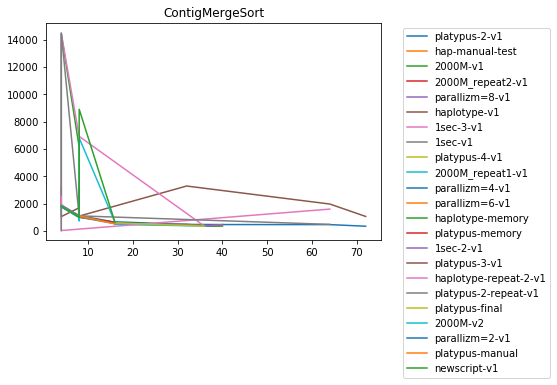

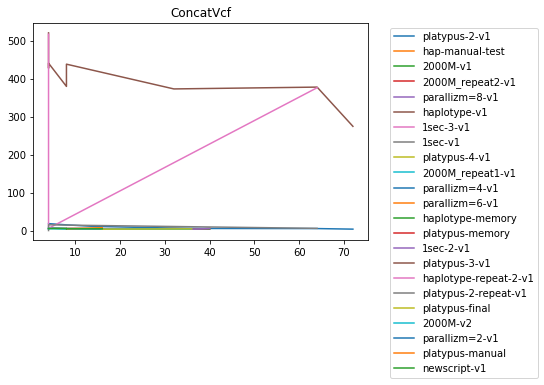

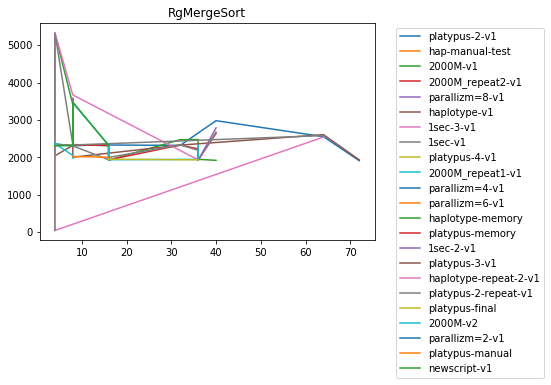

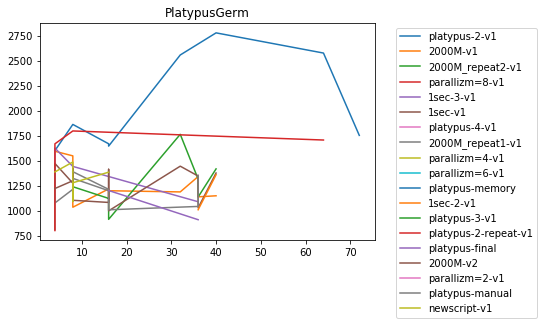

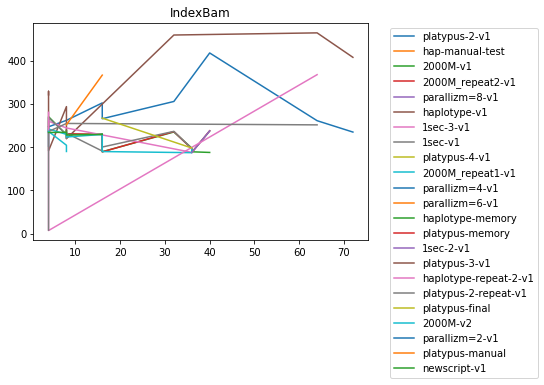

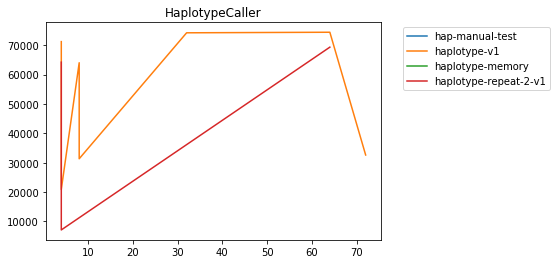

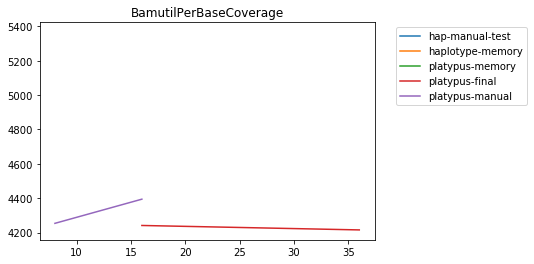

In [21]:
for k in xome_tools:
    temp = xome_data[(xome_data.tool==k)]
    fig, ax = plt.subplots()
    for t in xome_tags:
        tag_temp = temp[temp.tag==t]
        if tag_temp.cpus.size>0:
            tag_temp = tag_temp.sort_values(by='cpus')
            ax.plot(tag_temp.cpus,tag_temp.duration,label=t)
    legend = ax.legend(bbox_to_anchor=(1.05, 1))
    plt.title(k)
    plt.show()

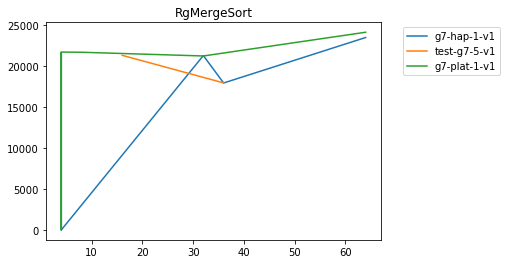

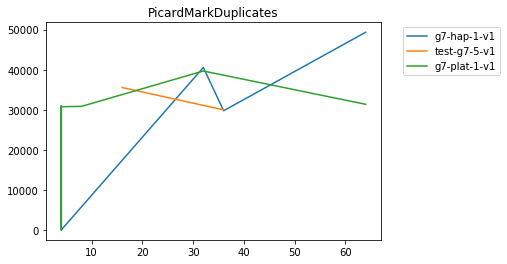

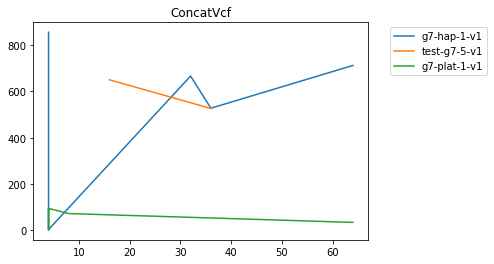

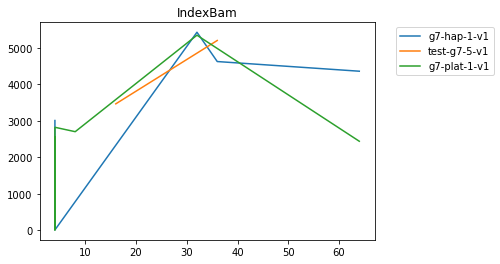

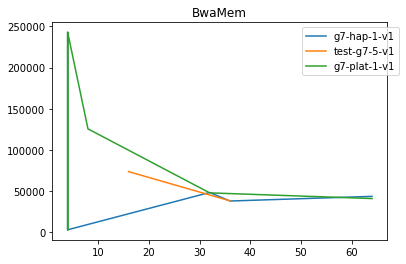

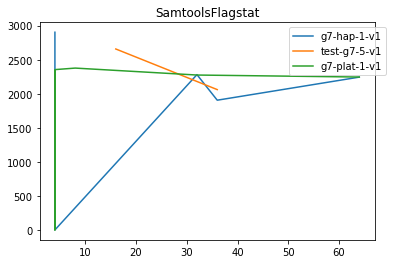

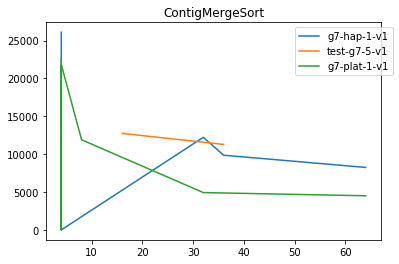

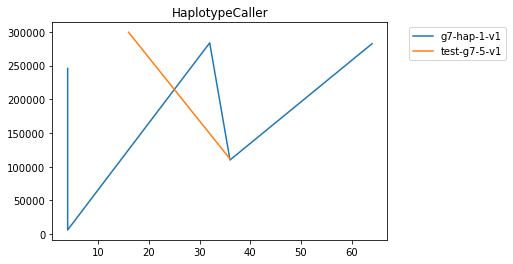

In [23]:
for k in genome_tools:
    temp = genome_data[(genome_data.tool==k)]
    fig, ax = plt.subplots()
    for t in genome_tags:
        tag_temp = temp[temp.tag==t]
        if tag_temp.cpus.size>0:
            tag_temp = tag_temp.sort_values(by='cpus')
            ax.plot(tag_temp.cpus,tag_temp.duration,label=t)
    legend = ax.legend(bbox_to_anchor=(1.05, 1))
    plt.title(k)
    plt.show()

# add core-count to memory variable

In [24]:
memper = pd.DataFrame(columns=['memper'])
xome_data=xome_data.join(memper)
genome_data=genome_data.join(memper)

In [26]:
xome_data.memper  = xome_data.mem/xome_data.cpus
genome_data.memper  = genome_data.mem/genome_data.cpus

# aggregate workflows

In [29]:
xome_final = pd.DataFrame(columns = ['instance','tag','duration','cpus','mem','memper'])
for t in xome_tags:
    for k in xome_types:
        temp = xome_data[(xome_data.instance==k) & (xome_data.tag==t)]
        if temp.instance.size==8:
            final_dur=0
            for l in range(temp.instance.size):
                final_dur+=temp.iloc[l,].duration
            xome_final=xome_final.append(pd.DataFrame([[k,t,final_dur,temp.cpus.tolist()[0],temp.mem.tolist()[0],temp.memper.tolist()[0]]],columns=xome_final.columns))

In [30]:
genome_final = pd.DataFrame(columns = ['instance','tag','duration','cpus','mem','memper'])
for t in genome_tags:
    for k in genome_types:
        temp = genome_data[(genome_data.instance==k) & (genome_data.tag==t)]
        if temp.instance.size==8:
            final_dur=0
            for l in range(temp.instance.size):
                final_dur+=temp.iloc[l,].duration
            genome_final=genome_final.append(pd.DataFrame([[k,t,final_dur,temp.cpus.tolist()[0],temp.mem.tolist()[0],temp.memper.tolist()[0]]],columns=genome_final.columns))

In [31]:
xome_final_tags = xome_final.tag.unique()
genome_final_tags = genome_final.tag.unique()

# pipeline regression fitting

In [32]:
def func(x, a, b, c):
    return a/x + c

Xome pipline plots by tag
Bad xome pipelines: ['haplotype-v1']


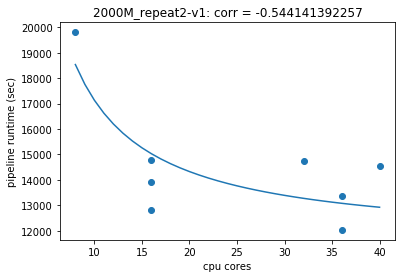

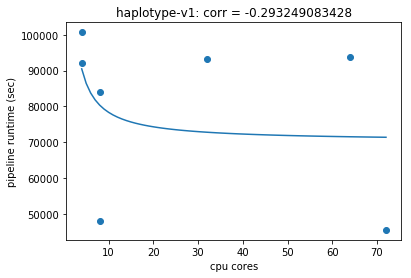

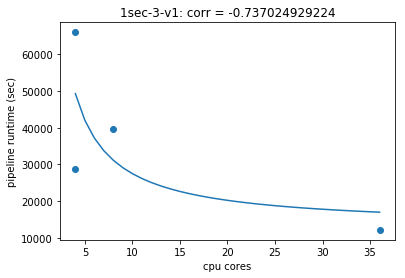

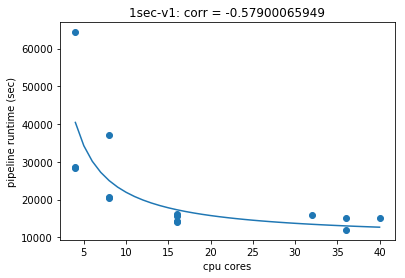

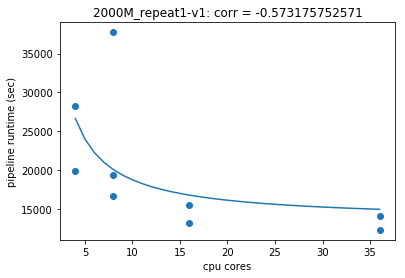

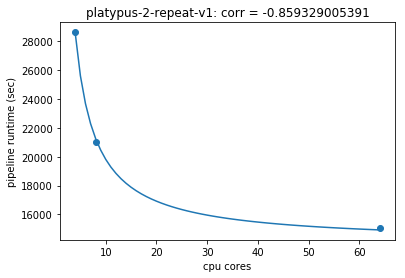

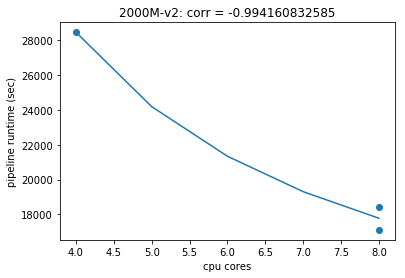

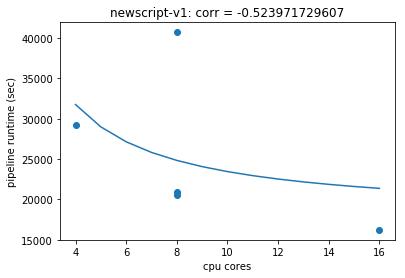

In [35]:
print("Xome pipline plots by tag")
bad_runs = []
for t in xome_final_tags:
    temp = xome_final[(xome_final.tag==t)&(xome_final.instance!='c5.xlarge')]
    temp = temp.sort_values(by = 'cpus')
    if temp.cpus.size>=3:
        x = temp.cpus.tolist()
        y = temp.duration.tolist()
        plt.figure()
        plt.scatter(temp.cpus,temp.duration)
        popt, pcov = curve_fit(func, x, y, maxfev=10000)
        x_max = temp.cpus.max()*100
        x_min = temp.cpus.min()*100
        x = []
        for k in range(int(x_min),int(x_max+1)):
            x.append(k/100)
        plt.plot(x, func(x, *popt))
        cor_val = str(temp.cpus.corr(temp.duration))
        if np.abs(float(cor_val)) < 0.5:
            bad_runs.append(t)
        plt.title(t+": corr = "+cor_val)
        plt.xlabel("cpu cores")
        plt.ylabel("pipeline runtime (sec)")
print("Bad xome pipelines: "+str(bad_runs))

Genome pipline plots by tag
Bad genome pipelines: ['g7-hap-1-v1']


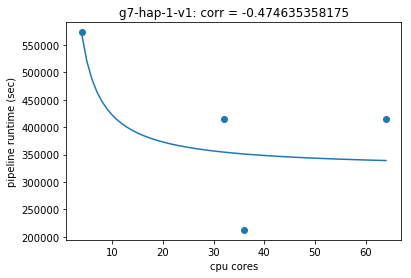

In [36]:
print("Genome pipline plots by tag")
bad_runs = []
for t in genome_final_tags:
    temp = genome_final[(genome_final.tag==t)&(genome_final.instance!='c5.xlarge')]
    temp = temp.sort_values(by = 'cpus')
    if temp.cpus.size>=3:
        x = temp.cpus.tolist()
        y = temp.duration.tolist()
        plt.figure()
        plt.scatter(temp.cpus,temp.duration)
        popt, pcov = curve_fit(func, x, y, maxfev=10000)
        x_max = temp.cpus.max()*100
        x_min = temp.cpus.min()*100
        x = []
        for k in range(int(x_min),int(x_max+1)):
            x.append(k/100)
        plt.plot(x, func(x, *popt))
        cor_val = str(temp.cpus.corr(temp.duration))
        if np.abs(float(cor_val)) < 0.5:
            bad_runs.append(t)
        plt.title(t+": corr = "+cor_val)
        plt.xlabel("cpu cores")
        plt.ylabel("pipeline runtime (sec)")
print("Bad genome pipelines: " +str(bad_runs))